In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')

from src.logregpca.config import data_dir_external
from src.logregpca.config import filename
from src.dataprocessor.data_reader import import_data

from src.dataprocessor.data_prepare import convertToBinary
from src.dataprocessor.data_prepare import createDummyVars

### Import data 

In [2]:
telecom = import_data(data_dir_external,filename)

2020-10-20 11:26:23,332 	 [INFO | data_reader.py:8] > importing data from churn_data.csv,customer_data.csv,internet_data.csv
2020-10-20 11:26:23,516 	 [DEBUG | data_reader.py:14] > file import success


Generate new instance


### Analyze dataframe

In [3]:
pd. set_option('display.max_columns', 500)
telecom.head()

customerID  tenure PhoneService        Contract PaperlessBilling  \
0  7590-VHVEG       1           No  Month-to-month              Yes   
1  5575-GNVDE      34          Yes        One year               No   
2  3668-QPYBK       2          Yes  Month-to-month              Yes   
3  7795-CFOCW      45           No        One year               No   
4  9237-HQITU       2          Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges Churn  gender  \
0           Electronic check           29.85        29.85    No  Female   
1               Mailed check           56.95       1889.5    No    Male   
2               Mailed check           53.85       108.15   Yes    Male   
3  Bank transfer (automatic)           42.30      1840.75    No    Male   
4           Electronic check           70.70       151.65   Yes  Female   

   SeniorCitizen Partner Dependents     MultipleLines InternetService  \
0              0     Yes         No  No phone service             DSL   
1              0      No         No                No             DSL   
2              0      No         No                No             DSL   
3              0      No         No  No phone service             DSL   
4              0      No         No                No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies  
0              No  
1              No  
2              No  
3              No  
4              No

In [4]:
telecom.describe()

tenure  MonthlyCharges  SeniorCitizen
count  7043.000000     7043.000000    7043.000000
mean     32.371149       64.761692       0.162147
std      24.559481       30.090047       0.368612
min       0.000000       18.250000       0.000000
25%       9.000000       35.500000       0.000000
50%      29.000000       70.350000       0.000000
75%      55.000000       89.850000       0.000000
max      72.000000      118.750000       1.000000

In [5]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(1), int64(2), obj

#### Checking for Missing Values and Inputing Them

In [6]:
telecom.TotalCharges = telecom.TotalCharges.replace([' '],np.nan)
telecom.isnull().sum()

customerID           0
tenure               0
PhoneService         0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
dtype: int64

- TotalCharges should be of type number
- columns with binary values that are to be converted: PhoneService, PaperlessBilling, Churn, Partner, Dependents
- columns to create dummy variables: 'Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
- handle missing values
- check for missing values again

### Data Cleaning

In [7]:
from src.dataprocessor.data_prepare import convertColToNumeric

telecom = convertColToNumeric(telecom, 'TotalCharges')

In [8]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(2), int64(2), ob

#### Handle missing values

In [9]:
from src.dataprocessor.data_prepare import dropMissingValuesInRow
telecom = dropMissingValuesInRow(telecom,'TotalCharges')

### Exploratory Data Analysis

In [10]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']
cat_cols = list([ele for ele in telecom.columns if ele not in num_cols])
cat_cols.remove('customerID')

#### Univariate Analysis

In [11]:
from src.visualization.eda_univariate import univar_num_plots
from src.visualization.eda_univariate import univar_cat_plots
from src.visualization.eda_core import eda_print_univar_graphs

plt.ioff()

/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: Matpl

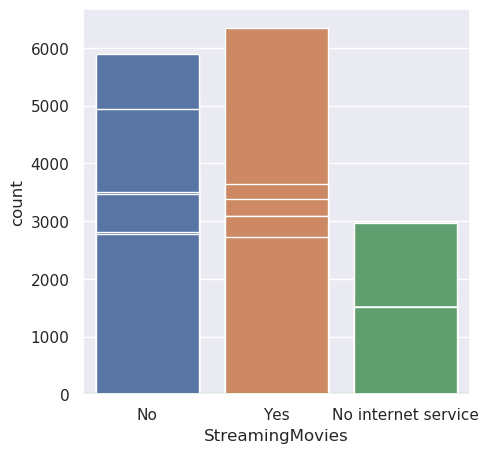

In [12]:
univar_num_plots(telecom,num_cols)
univar_cat_plots(telecom,cat_cols)

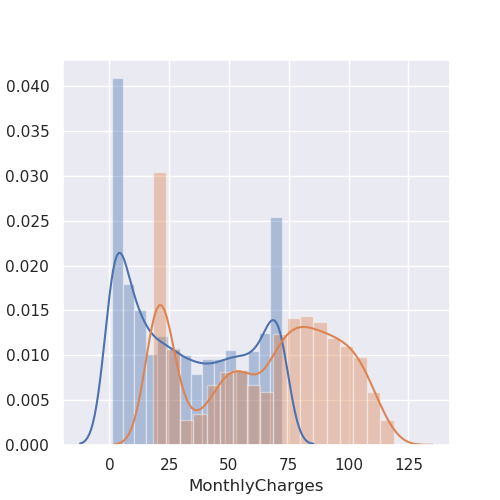

../reports/eda/univar_MonthlyCharges.png


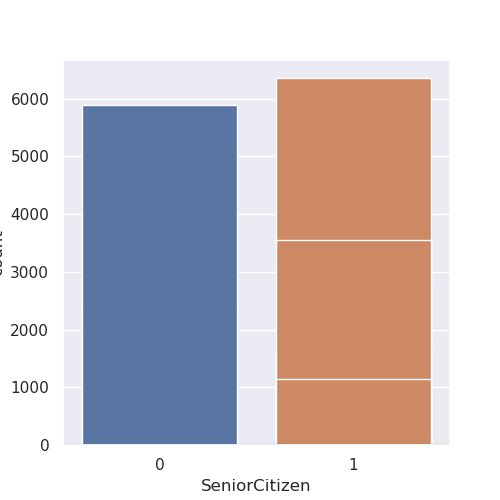

../reports/eda/univar_SeniorCitizen.png


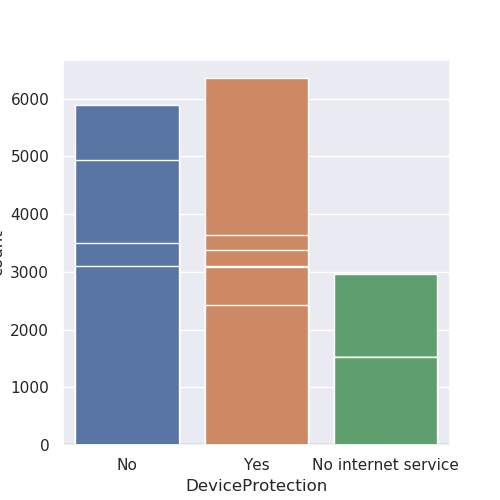

../reports/eda/univar_DeviceProtection.png


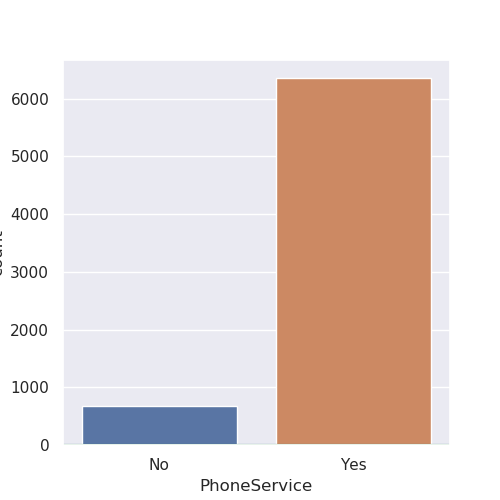

../reports/eda/univar_PhoneService.png


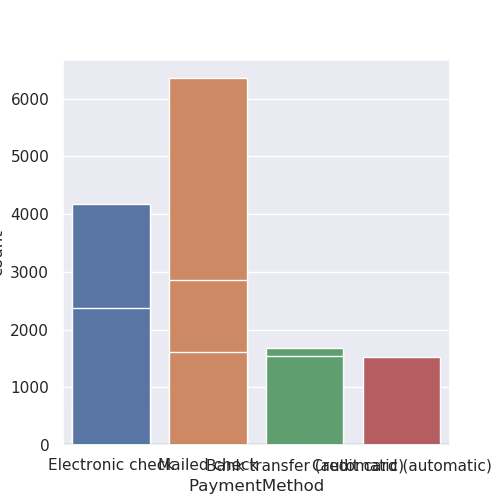

../reports/eda/univar_PaymentMethod.png


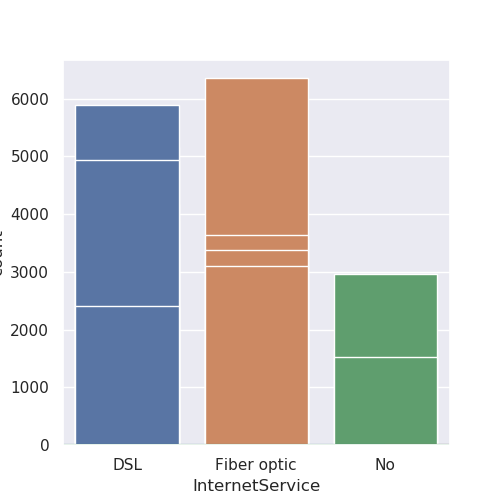

../reports/eda/univar_InternetService.png


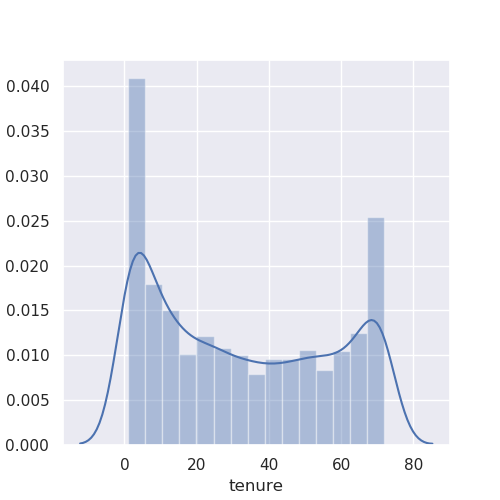

../reports/eda/univar_tenure.png


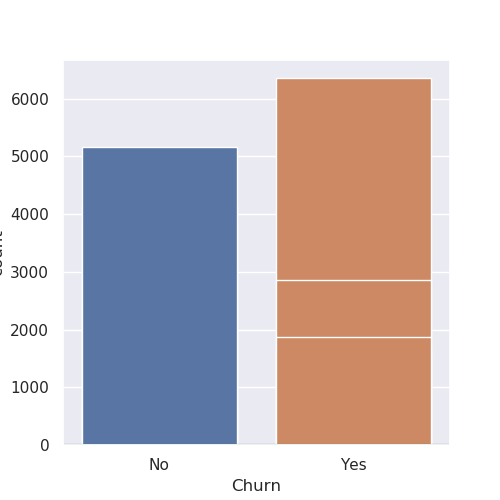

../reports/eda/univar_Churn.png


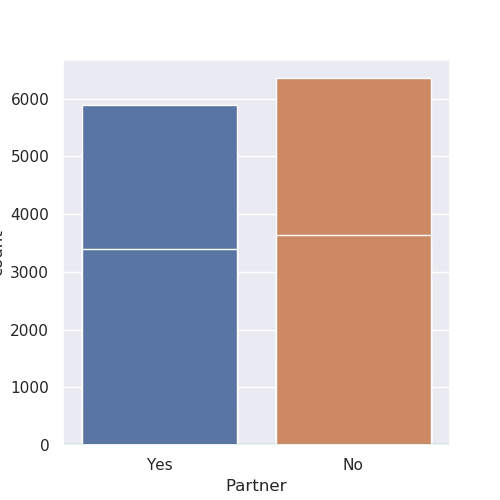

../reports/eda/univar_Partner.png


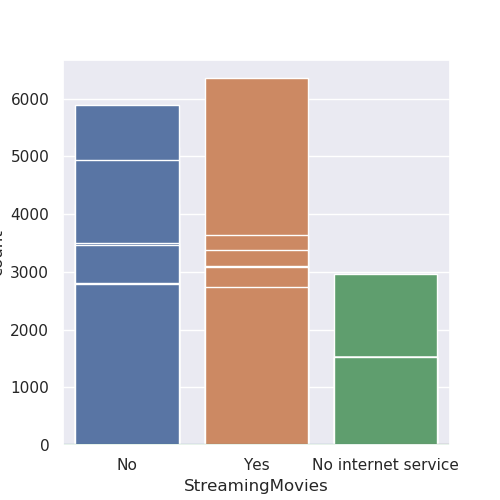

../reports/eda/univar_StreamingMovies.png


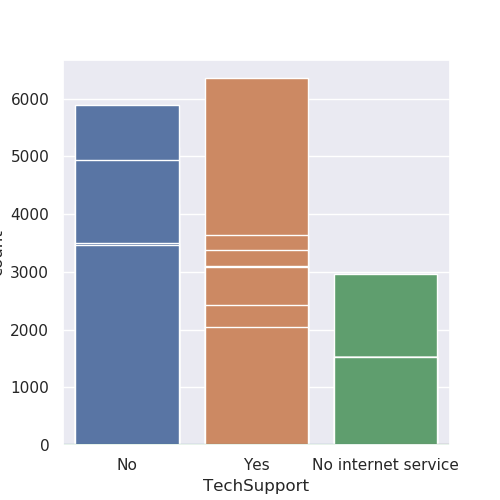

../reports/eda/univar_TechSupport.png


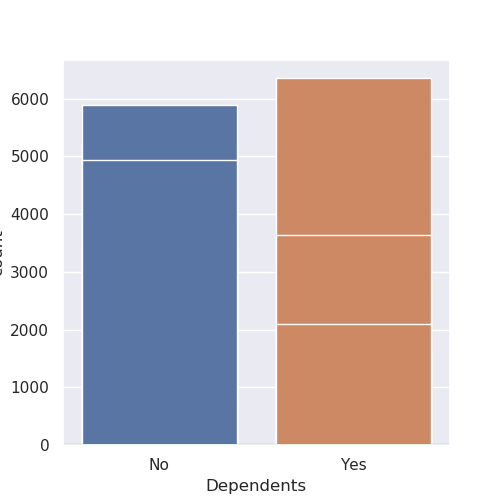

../reports/eda/univar_Dependents.png


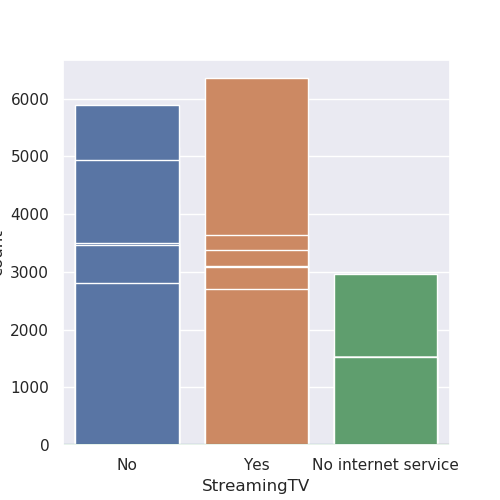

../reports/eda/univar_StreamingTV.png


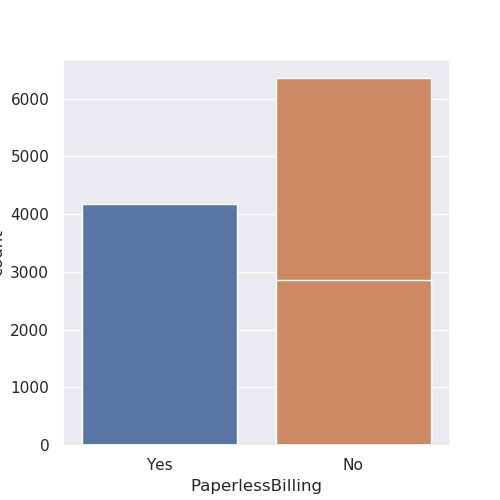

../reports/eda/univar_PaperlessBilling.png


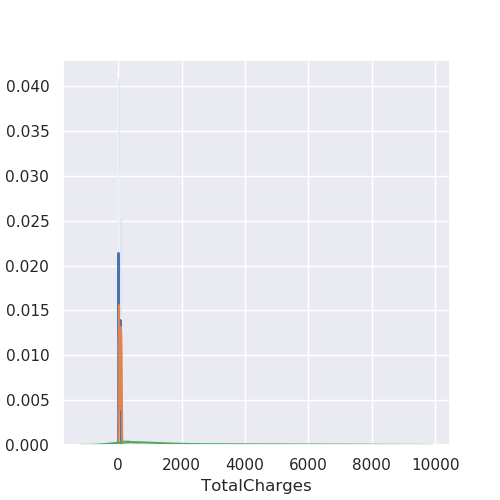

../reports/eda/univar_TotalCharges.png


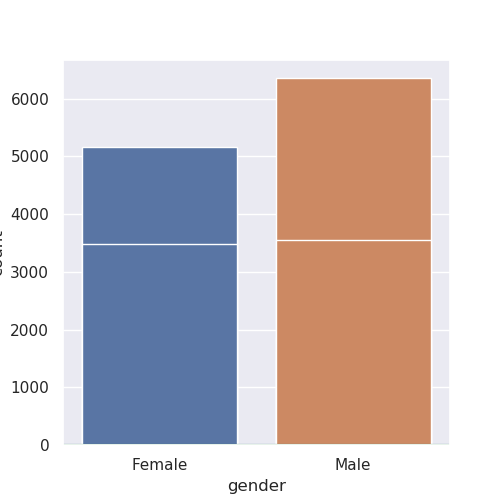

../reports/eda/univar_gender.png


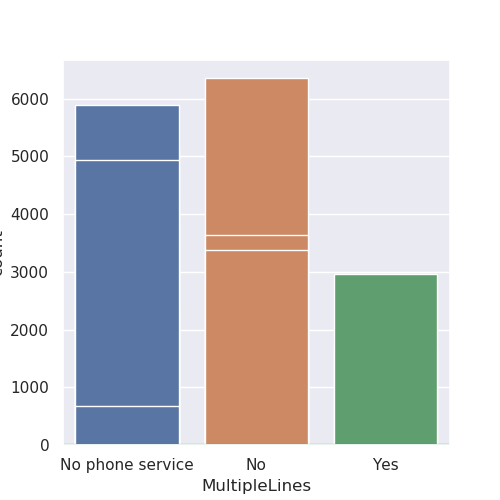

../reports/eda/univar_MultipleLines.png


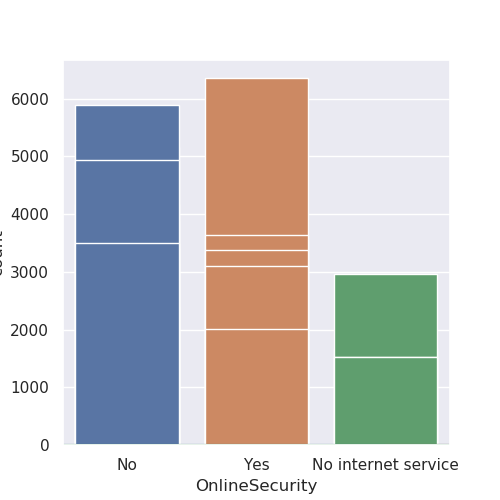

../reports/eda/univar_OnlineSecurity.png


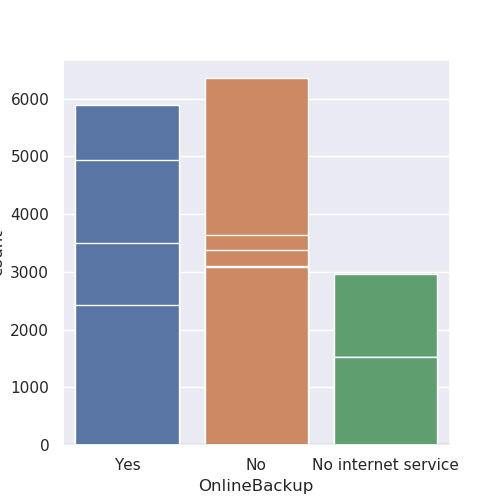

../reports/eda/univar_OnlineBackup.png


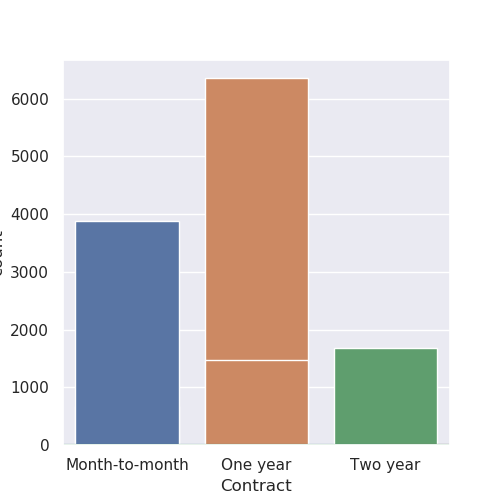

../reports/eda/univar_Contract.png


In [13]:
eda_print_univar_graphs()

#### Bivariate Analysis

In [14]:
from src.visualization.eda_bivariate import bivar_cat_plots
from src.visualization.eda_bivariate import bivar_num_plots
from src.visualization.eda_core import eda_print_bivar_graphs

2020-10-20 11:26:34,162 	 [INFO | eda_bivariate.py:19] > Bivariate categorical plots
2020-10-20 11:26:34,171 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column PhoneService
2020-10-20 11:26:34,865 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column Contract
2020-10-20 11:26:35,737 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column PaperlessBilling
2020-10-20 11:26:36,829 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column PaymentMethod
2020-10-20 11:26:38,293 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column Churn
2020-10-20 11:26:39,978 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column gender
2020-10-20 11:26:41,914 	 [INFO | eda_bivariate.py:24] > Bivariate analysis for num column: tenure and cat column SeniorCitizen
2020-10-20 11:26:44,136 	 [INFO | eda

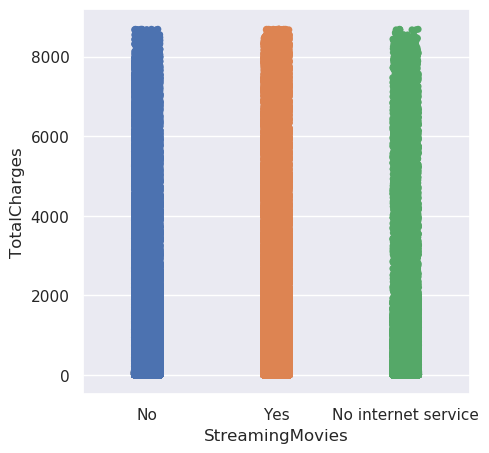

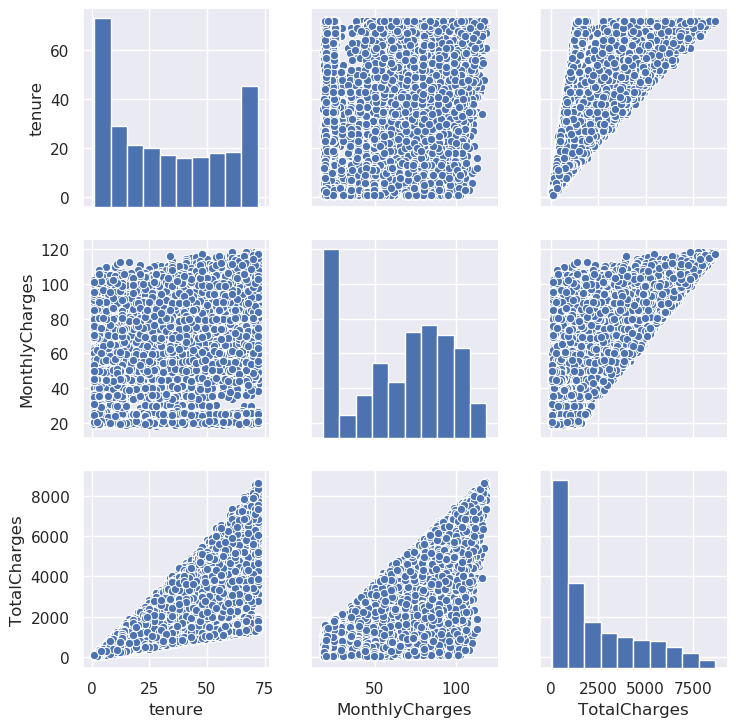

In [15]:
#for testing use nc and cc
nc = ['tenure','TotalCharges']
cc = ['OnlineBackup','Contract','PaymentMethod']

bivar_cat_plots(telecom,num_cols,cat_cols)
bivar_num_plots(telecom,num_cols)

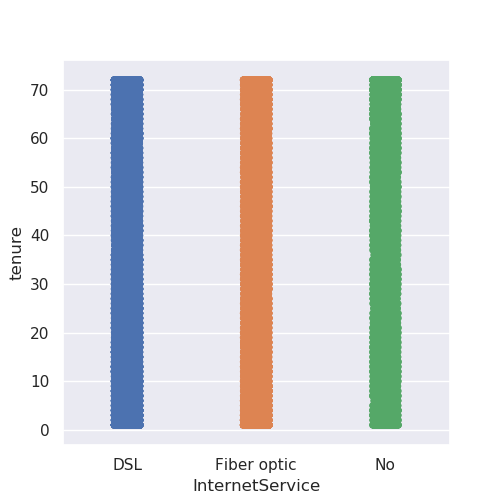

../reports/eda/bivar_tenure_InternetService.png


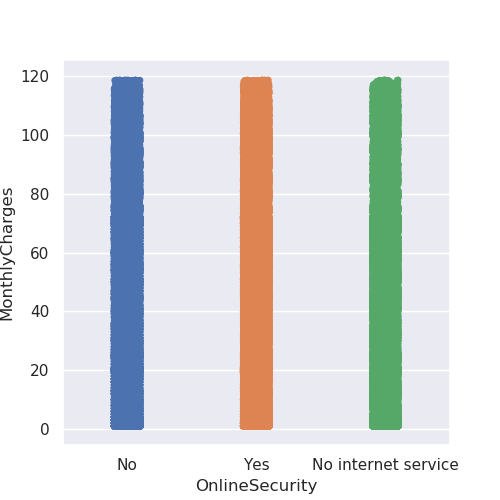

../reports/eda/bivar_MonthlyCharges_OnlineSecurity.png


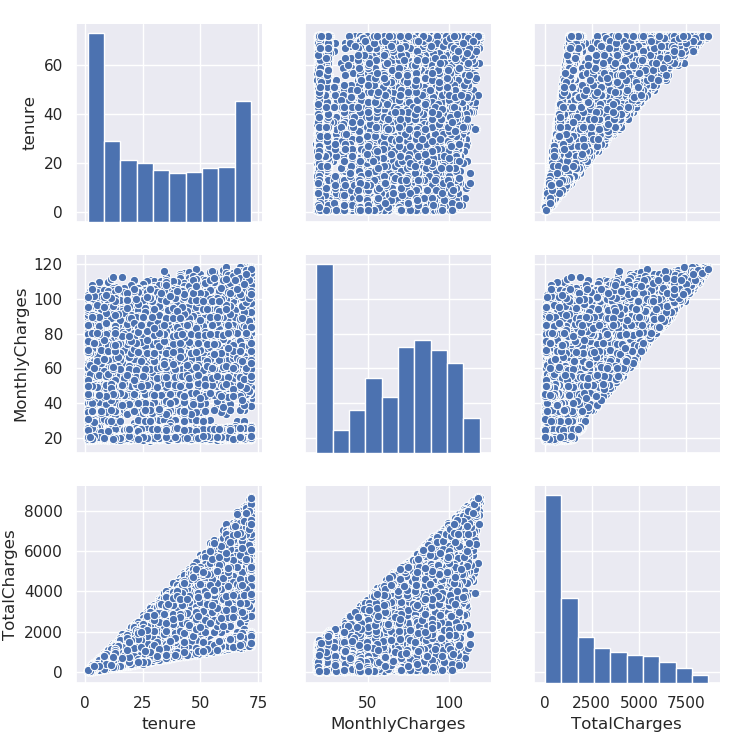

../reports/eda/bivar_pairplot.png


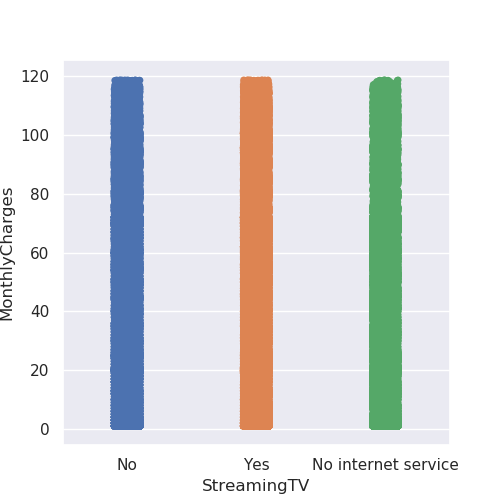

../reports/eda/bivar_MonthlyCharges_StreamingTV.png


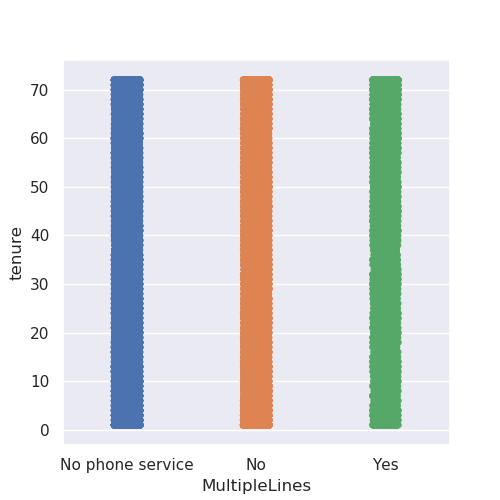

../reports/eda/bivar_tenure_MultipleLines.png


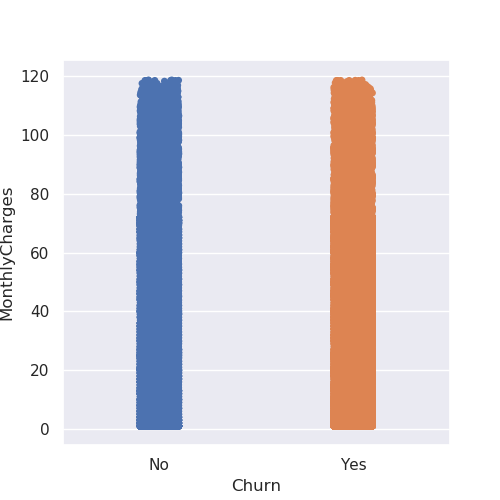

../reports/eda/bivar_MonthlyCharges_Churn.png


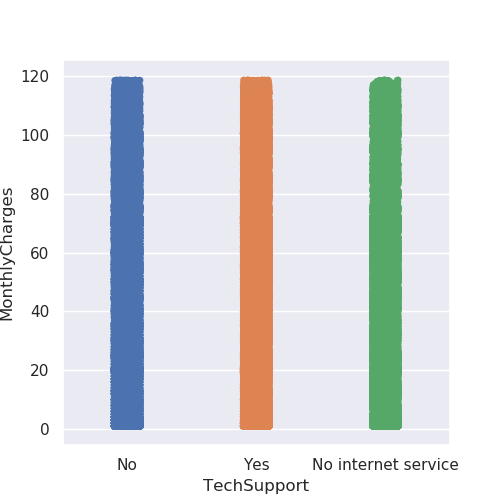

../reports/eda/bivar_MonthlyCharges_TechSupport.png


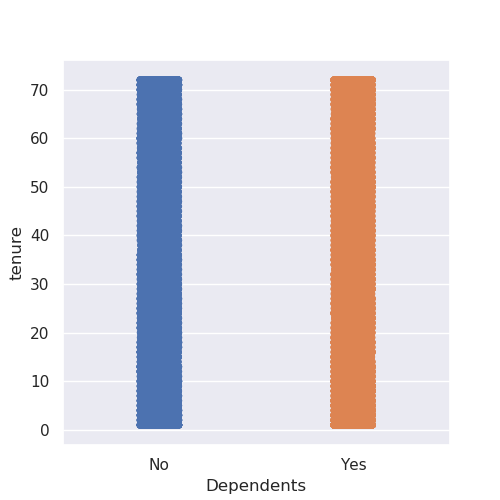

../reports/eda/bivar_tenure_Dependents.png


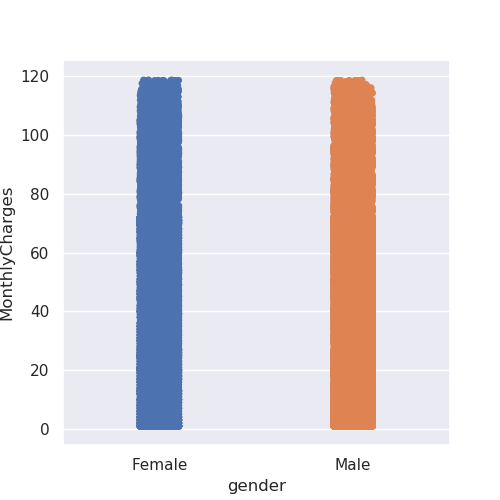

../reports/eda/bivar_MonthlyCharges_gender.png


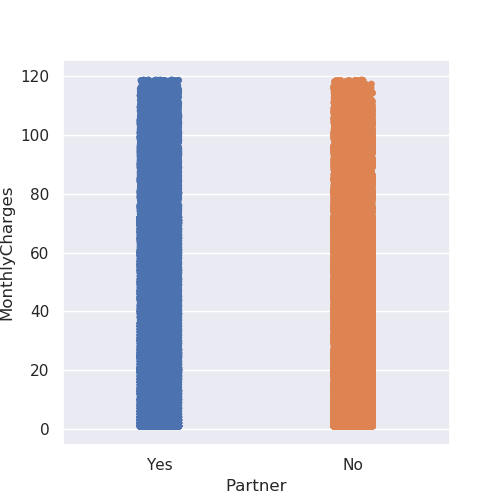

../reports/eda/bivar_MonthlyCharges_Partner.png


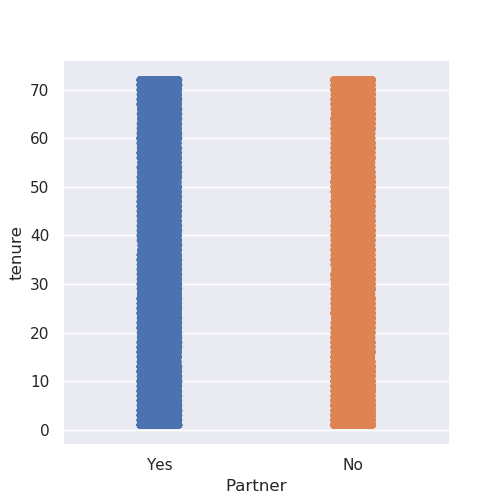

../reports/eda/bivar_tenure_Partner.png


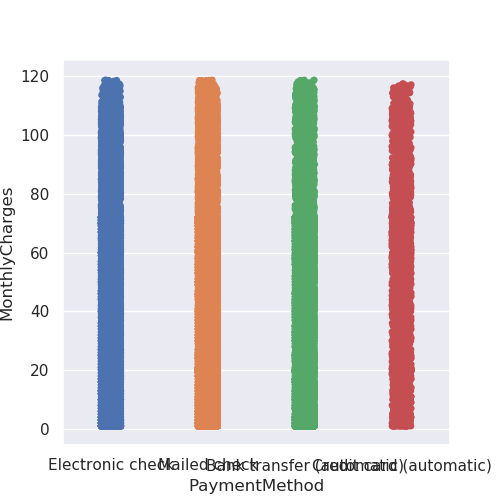

../reports/eda/bivar_MonthlyCharges_PaymentMethod.png


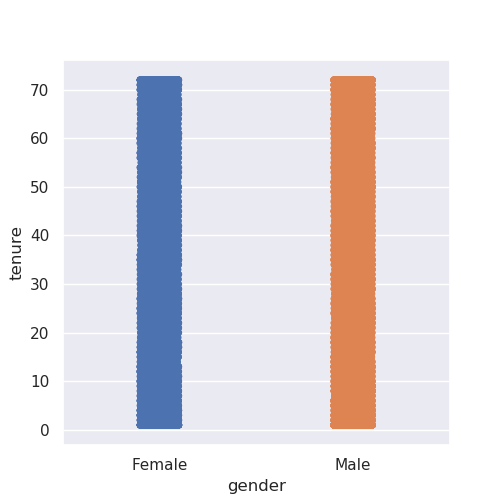

../reports/eda/bivar_tenure_gender.png


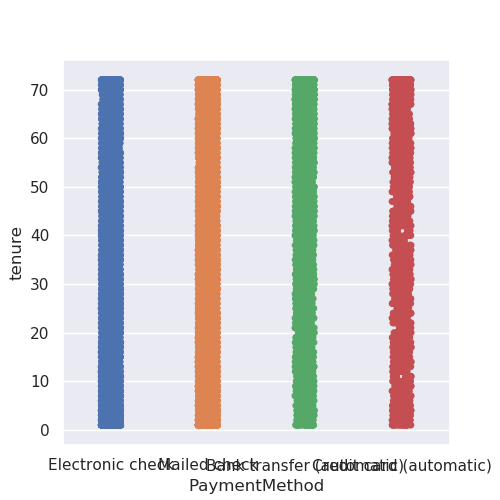

../reports/eda/bivar_tenure_PaymentMethod.png


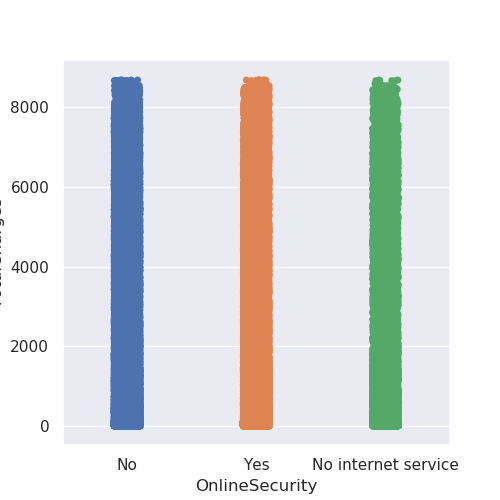

../reports/eda/bivar_TotalCharges_OnlineSecurity.png


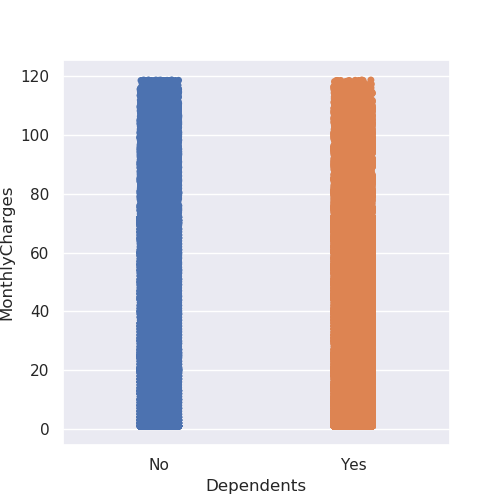

../reports/eda/bivar_MonthlyCharges_Dependents.png


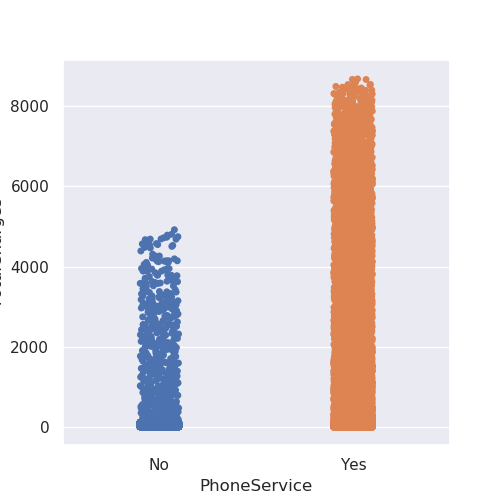

../reports/eda/bivar_TotalCharges_PhoneService.png


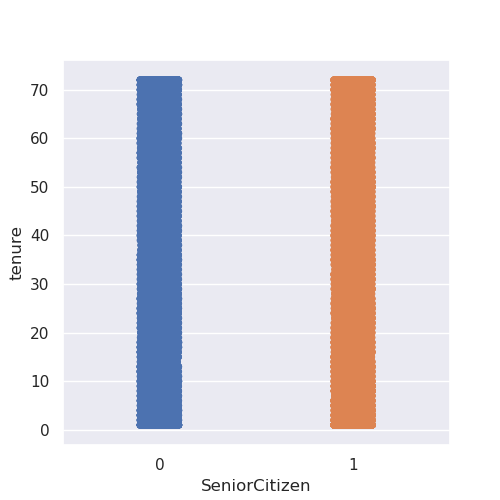

../reports/eda/bivar_tenure_SeniorCitizen.png


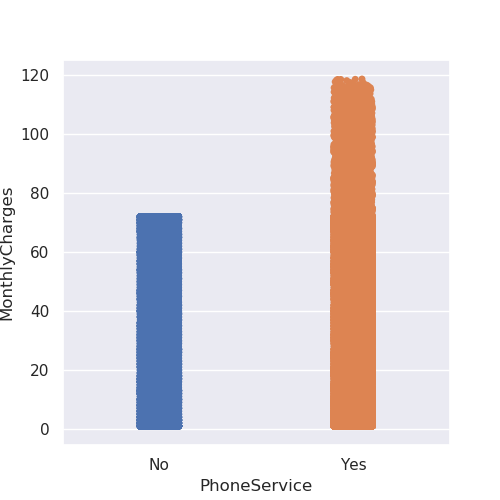

../reports/eda/bivar_MonthlyCharges_PhoneService.png


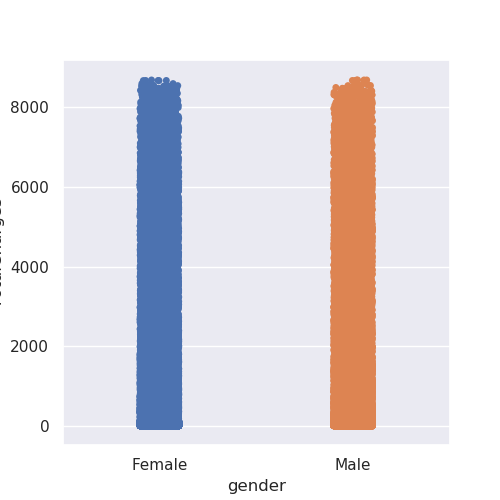

../reports/eda/bivar_TotalCharges_gender.png


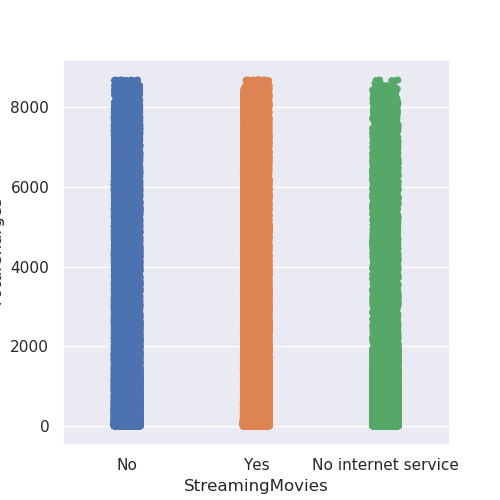

../reports/eda/bivar_TotalCharges_StreamingMovies.png


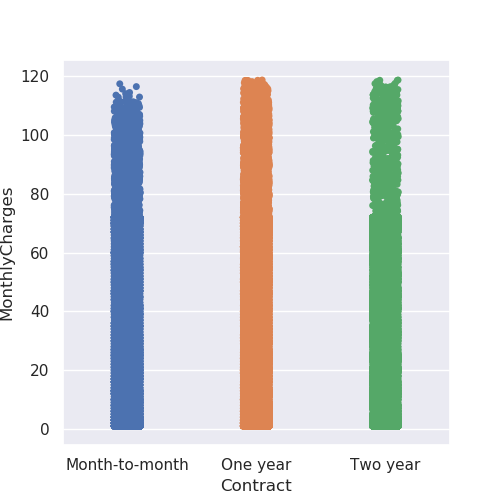

../reports/eda/bivar_MonthlyCharges_Contract.png


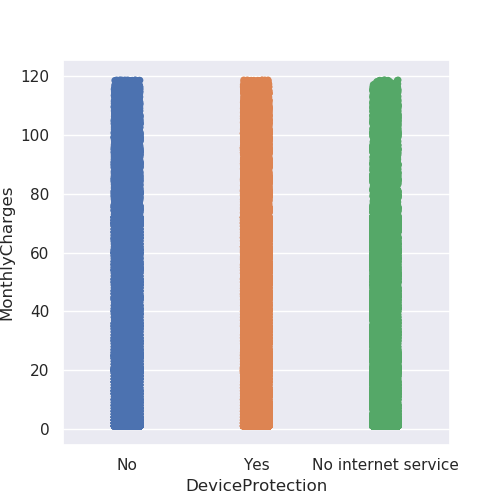

../reports/eda/bivar_MonthlyCharges_DeviceProtection.png


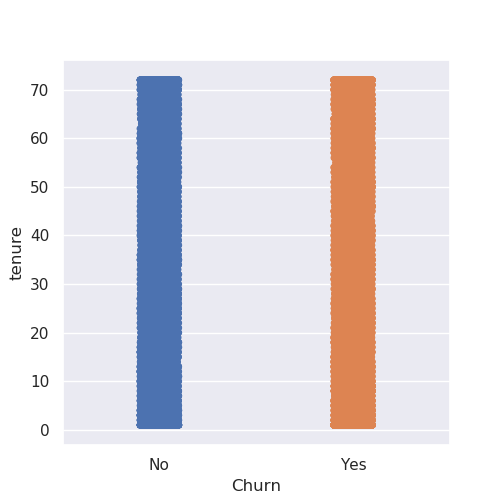

../reports/eda/bivar_tenure_Churn.png


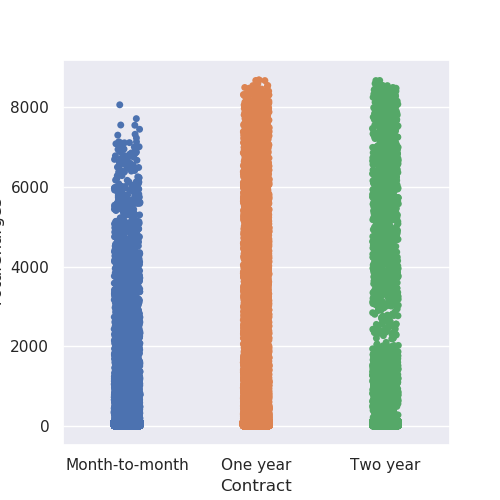

../reports/eda/bivar_TotalCharges_Contract.png


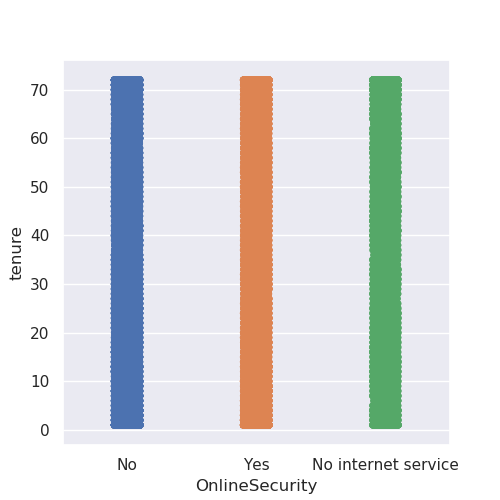

../reports/eda/bivar_tenure_OnlineSecurity.png


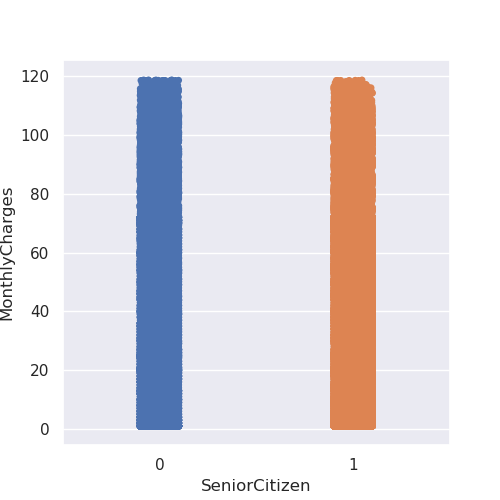

../reports/eda/bivar_MonthlyCharges_SeniorCitizen.png


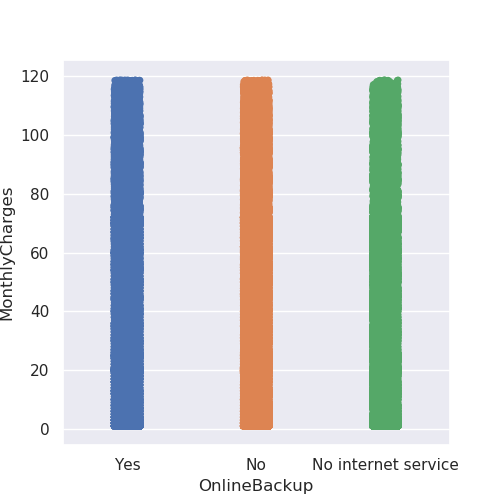

../reports/eda/bivar_MonthlyCharges_OnlineBackup.png


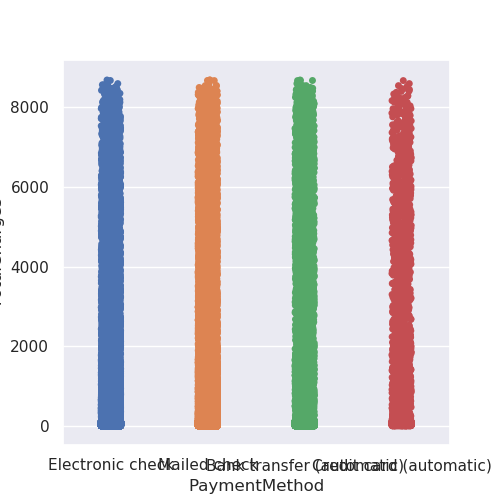

../reports/eda/bivar_TotalCharges_PaymentMethod.png


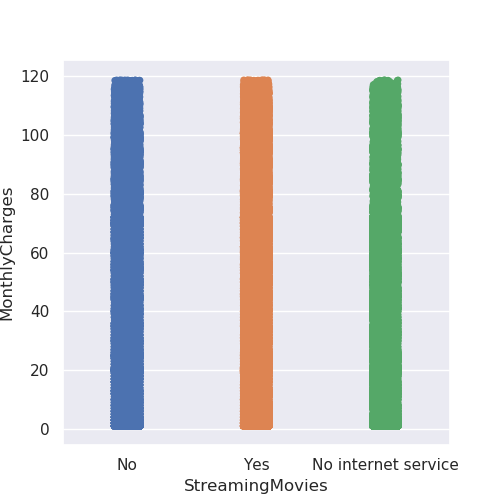

../reports/eda/bivar_MonthlyCharges_StreamingMovies.png


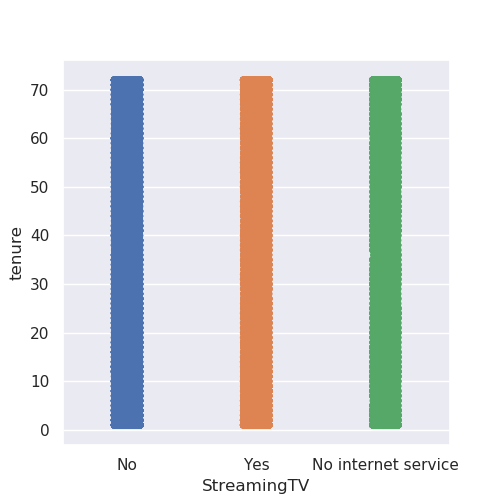

../reports/eda/bivar_tenure_StreamingTV.png


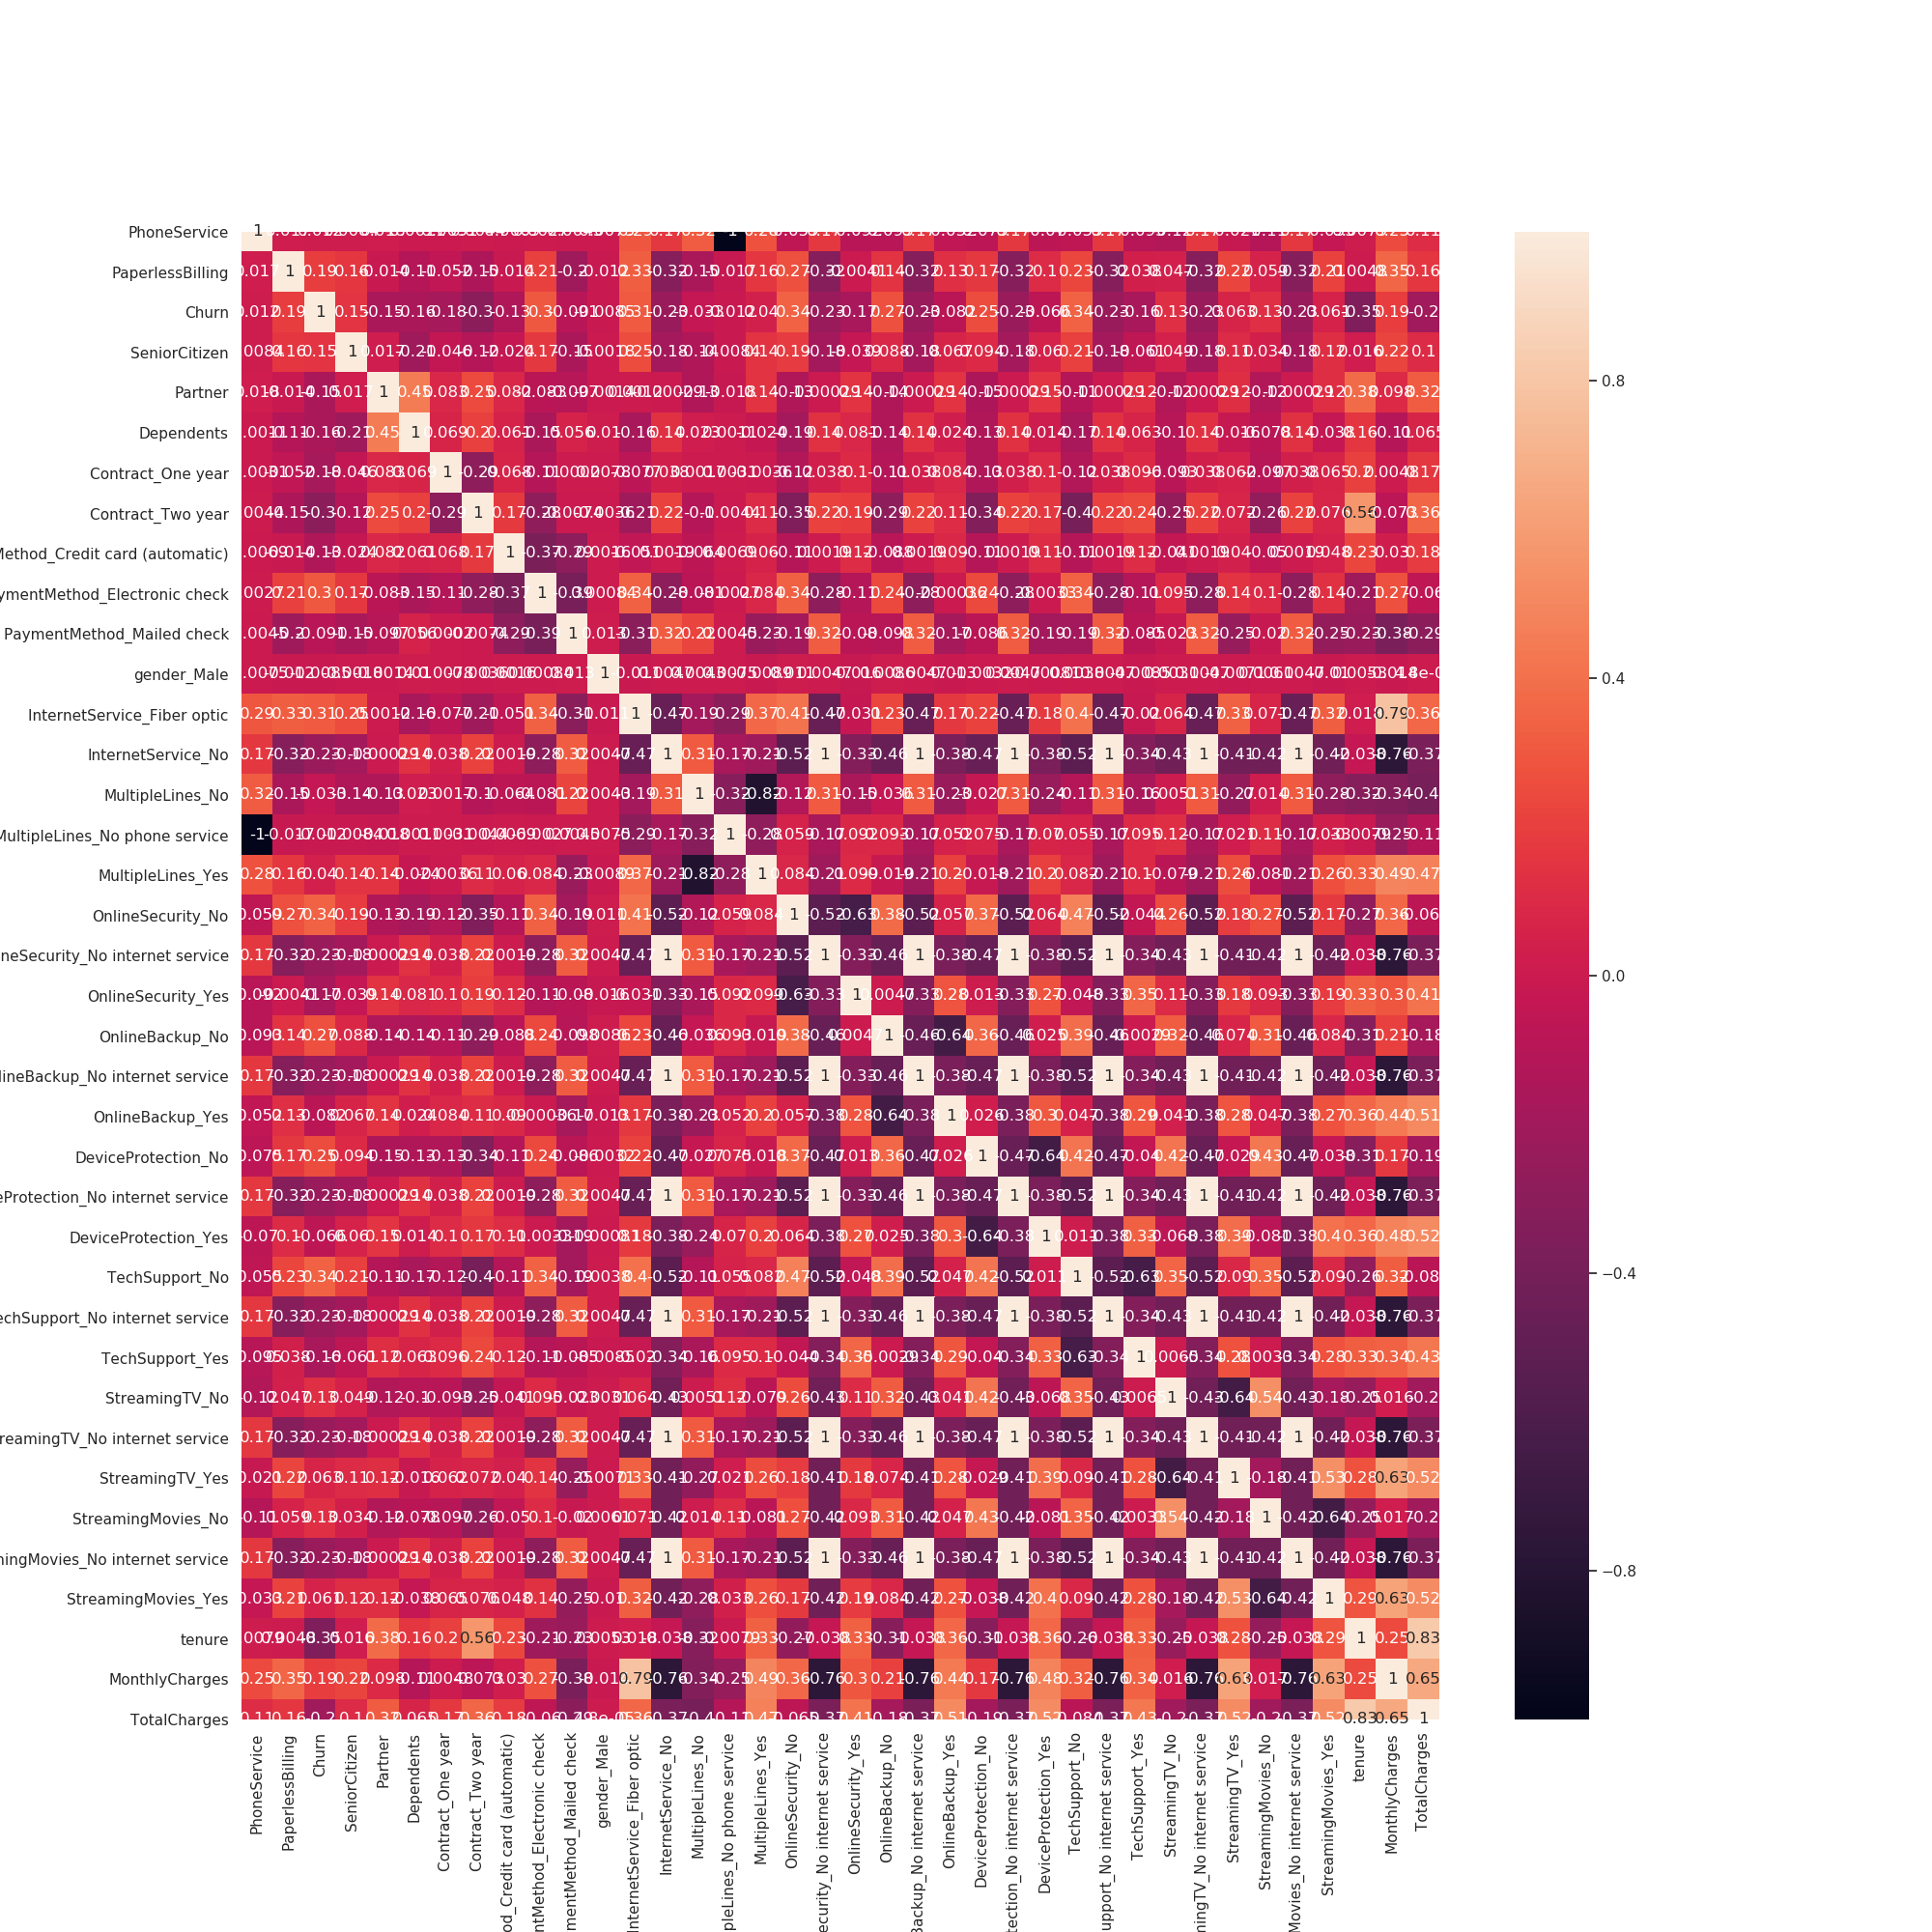

../reports/eda/bivar_corr_beforePCA.png


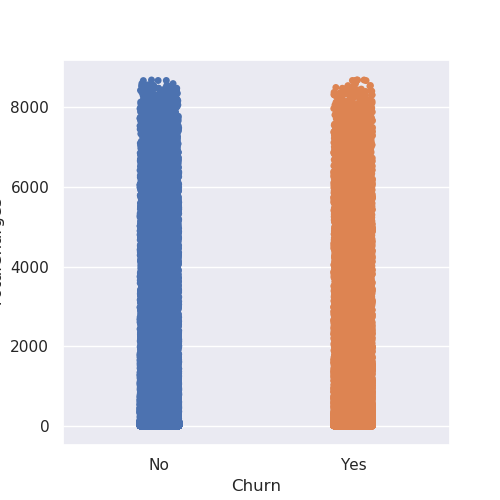

../reports/eda/bivar_TotalCharges_Churn.png


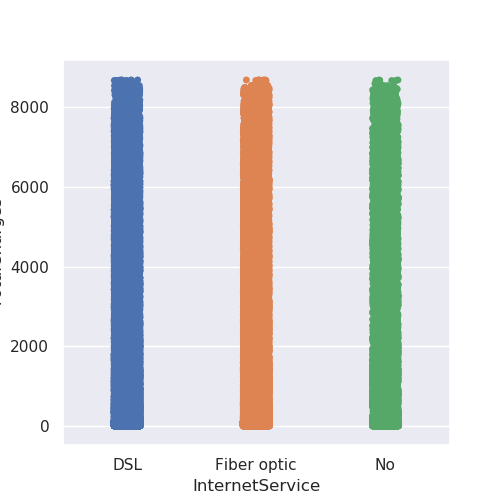

../reports/eda/bivar_TotalCharges_InternetService.png


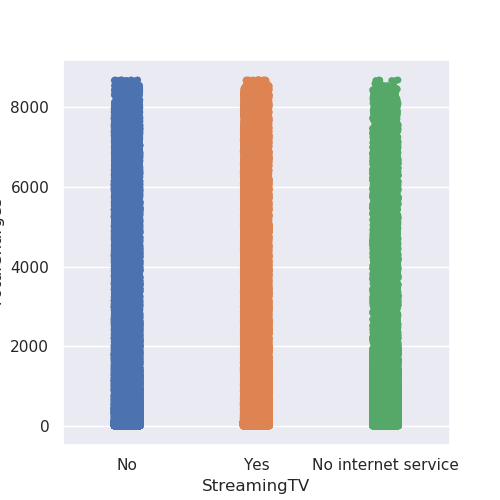

../reports/eda/bivar_TotalCharges_StreamingTV.png


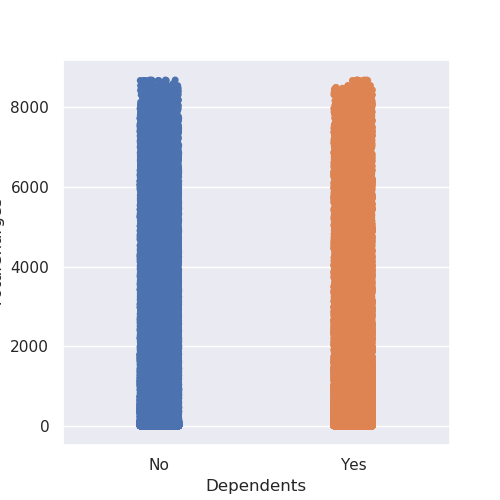

../reports/eda/bivar_TotalCharges_Dependents.png


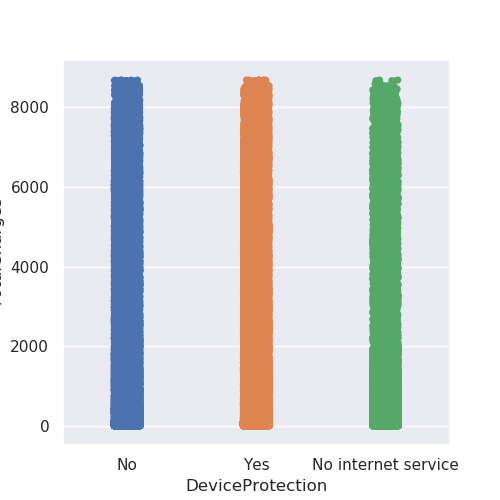

../reports/eda/bivar_TotalCharges_DeviceProtection.png


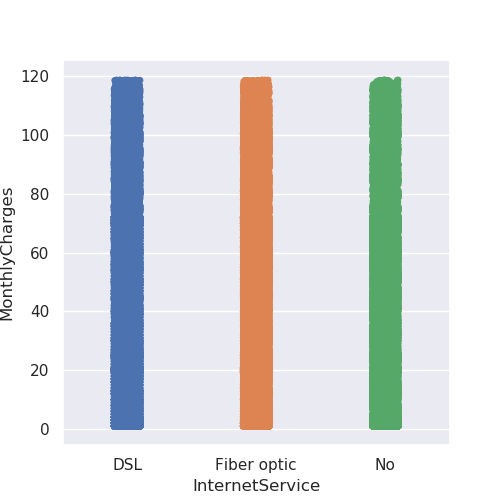

../reports/eda/bivar_MonthlyCharges_InternetService.png


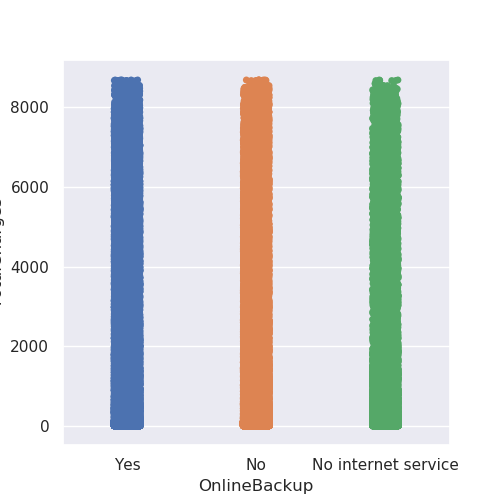

../reports/eda/bivar_TotalCharges_OnlineBackup.png


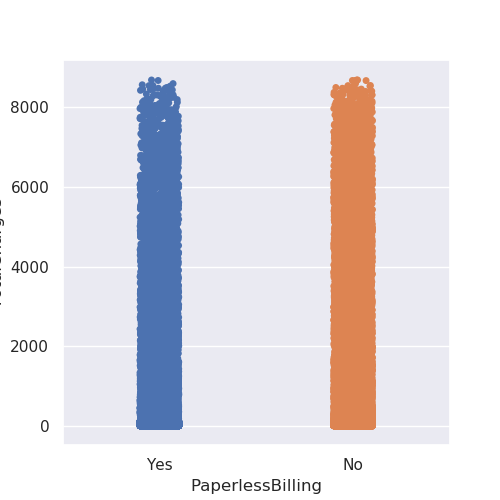

../reports/eda/bivar_TotalCharges_PaperlessBilling.png


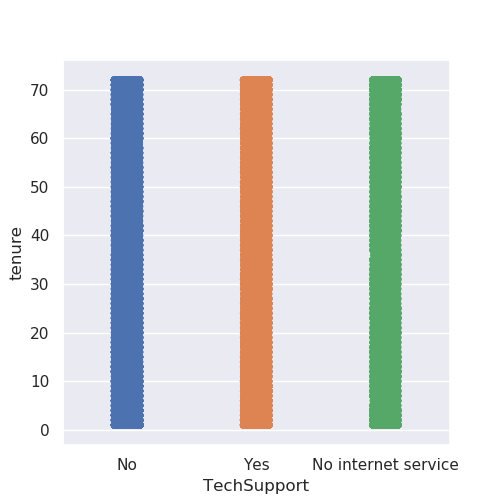

../reports/eda/bivar_tenure_TechSupport.png


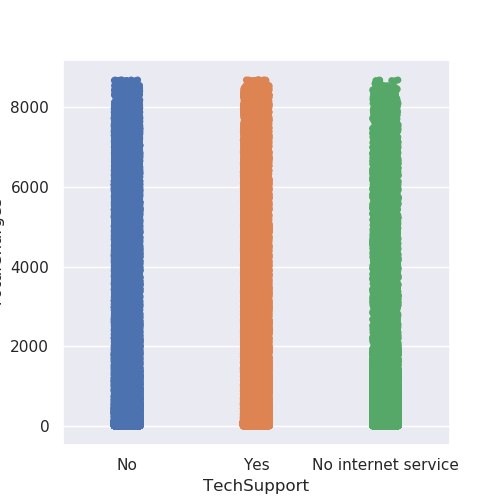

../reports/eda/bivar_TotalCharges_TechSupport.png


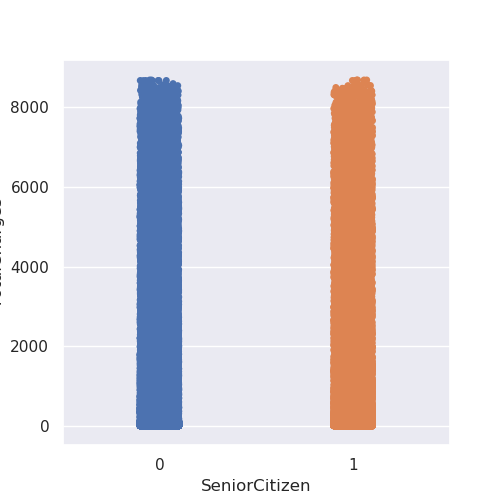

../reports/eda/bivar_TotalCharges_SeniorCitizen.png


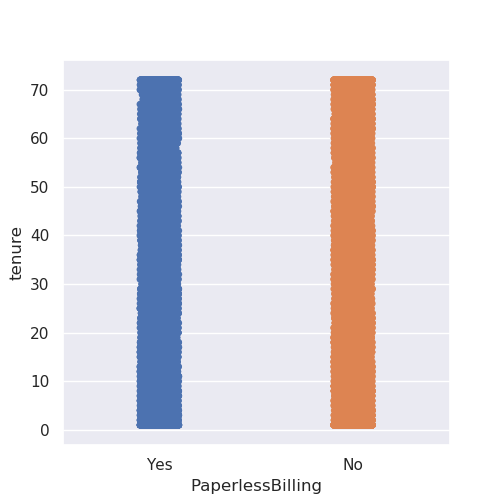

../reports/eda/bivar_tenure_PaperlessBilling.png


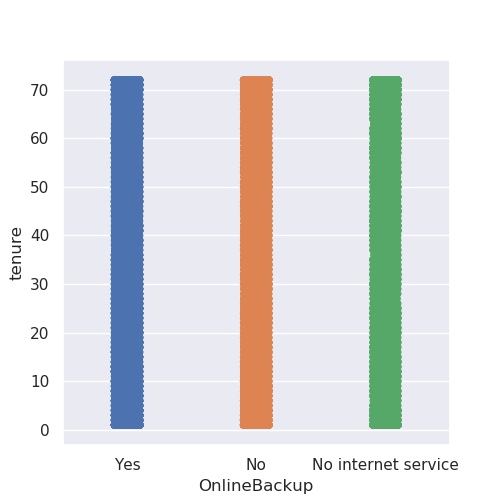

../reports/eda/bivar_tenure_OnlineBackup.png


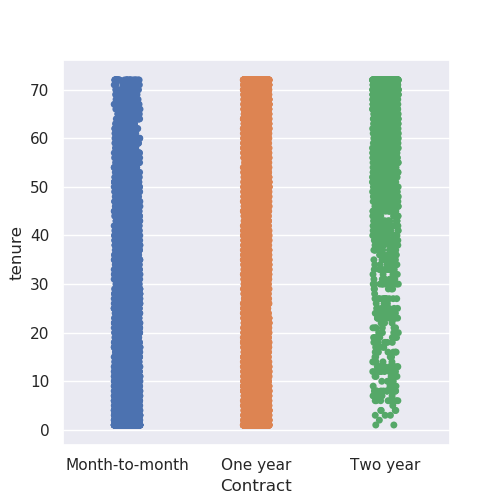

../reports/eda/bivar_tenure_Contract.png


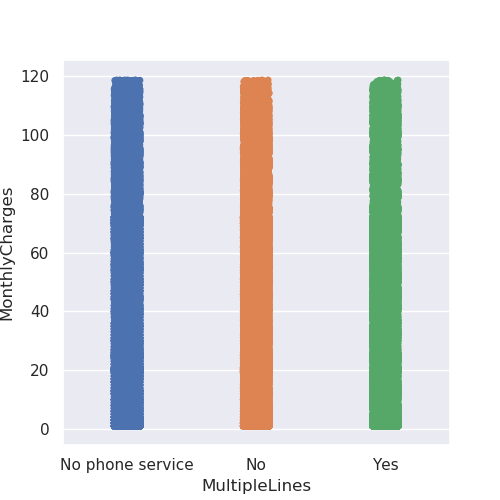

../reports/eda/bivar_MonthlyCharges_MultipleLines.png


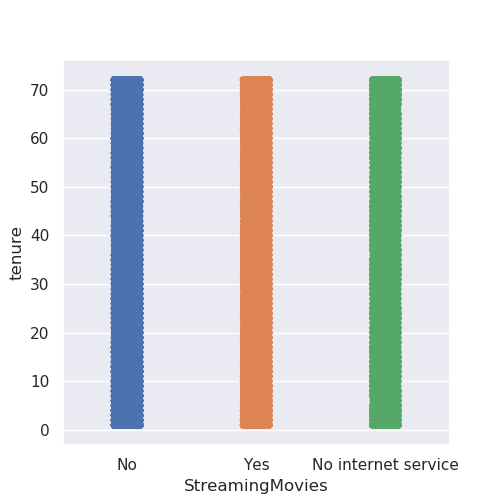

../reports/eda/bivar_tenure_StreamingMovies.png


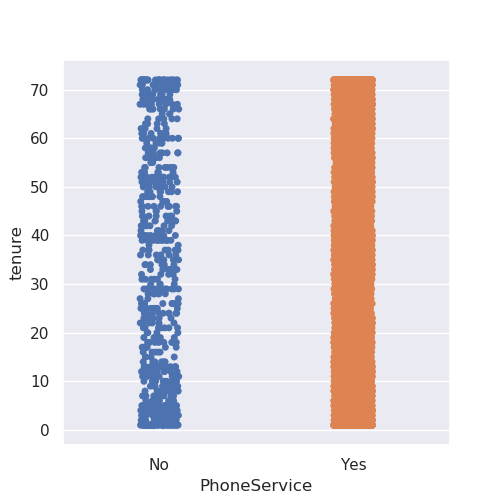

../reports/eda/bivar_tenure_PhoneService.png


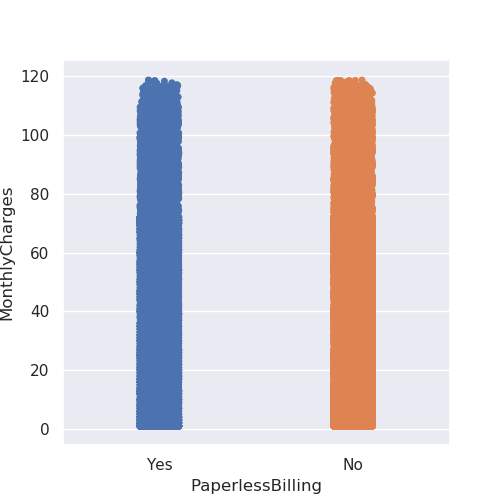

../reports/eda/bivar_MonthlyCharges_PaperlessBilling.png


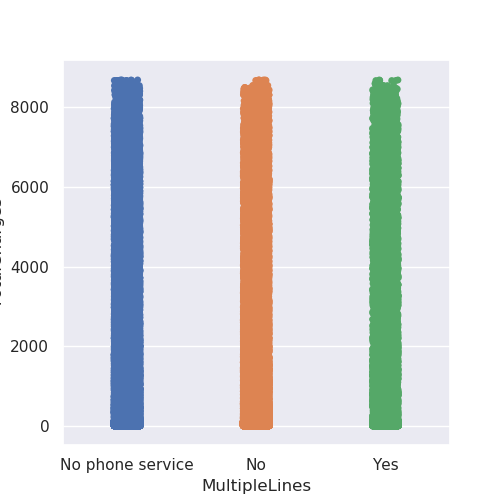

../reports/eda/bivar_TotalCharges_MultipleLines.png


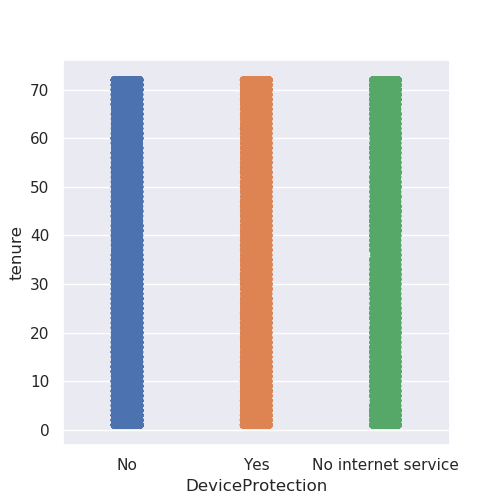

../reports/eda/bivar_tenure_DeviceProtection.png


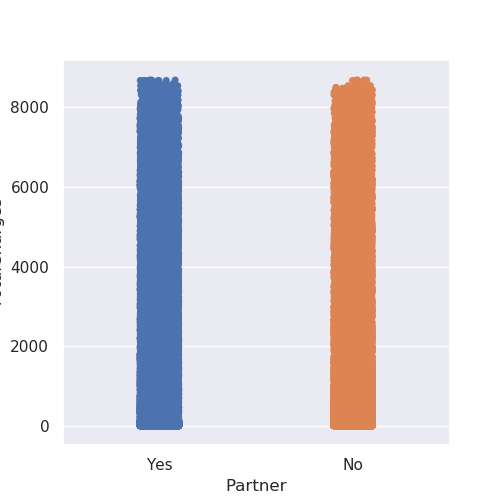

../reports/eda/bivar_TotalCharges_Partner.png


In [16]:
eda_print_bivar_graphs()

plt.ion()


### Data Preparation

#### Dummy Variable Creation

In [17]:
# columns with binary values that are to be converted
binary_cols = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
telecom = convertToBinary(telecom,binary_cols)

In [18]:
dropfirstcols = ['Contract','PaymentMethod','gender','InternetService']
remainingcols = ['MultipleLines','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
telecom = createDummyVars(telecom,dropfirstcols,dropfirst=True)
telecom = createDummyVars(telecom,remainingcols)

2020-10-20 11:33:34,652 	 [INFO | data_prepare.py:17] > dummy vars creation for cols: 
2020-10-20 11:33:34,655 	 [INFO | data_prepare.py:18] > ['Contract', 'PaymentMethod', 'gender', 'InternetService']
2020-10-20 11:33:34,792 	 [INFO | data_prepare.py:17] > dummy vars creation for cols: 
2020-10-20 11:33:34,794 	 [INFO | data_prepare.py:18] > ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


In [19]:
telecom[num_cols].describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

### Feature Standardisation

In [20]:
from src.dataprocessor.data_prepare import normalizeData
telecom = normalizeData(telecom, num_cols)


In [21]:
telecom[num_cols].describe()

tenure  MonthlyCharges  TotalCharges
count  7.032000e+03    7.032000e+03  7.032000e+03
mean  -1.028756e-16   -1.356108e-15 -1.724951e-15
std    1.000000e+00    1.000000e+00  1.000000e+00
min   -1.280157e+00   -1.547173e+00 -9.989982e-01
25%   -9.542285e-01   -9.709078e-01 -8.301898e-01
50%   -1.394072e-01    1.845309e-01 -3.907873e-01
75%    9.198605e-01    8.330889e-01  6.667797e-01
max    1.612459e+00    1.793254e+00  2.824061e+00

#### Check Churn Rate

In [22]:
churn = round((sum(telecom['Churn'])/len(telecom['Churn'].index))*100,2)
churn

26.58

In [23]:
# drop CandidateID column
from src.dataprocessor.data_clean import dropMultipleCols
#candID = telecom['customerID']
#telecom = dropMultipleCols(telecom, ['customerID'])

##### 27% of users are discontinuing the services

### Model Building

In [24]:
from src.models.model_trainTestSplit import split_train_test
X_train, X_test, y_train, y_test = split_train_test(telecom, 'Churn',0.7)
candID_train = X_train['customerID']
candID_test = X_test['customerID']
X_train = dropMultipleCols(X_train, ['customerID'])
X_test = dropMultipleCols(X_test, ['customerID'])

2020-10-20 11:33:36,047 	 [INFO | model_trainTestSplit.py:20] > Train Test Split Success


#### Check Coorelation between independent variables before applying PCA

/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/naveenkumar/anaconda3/lib/python3.7/_collections_abc.py:841: Matpl

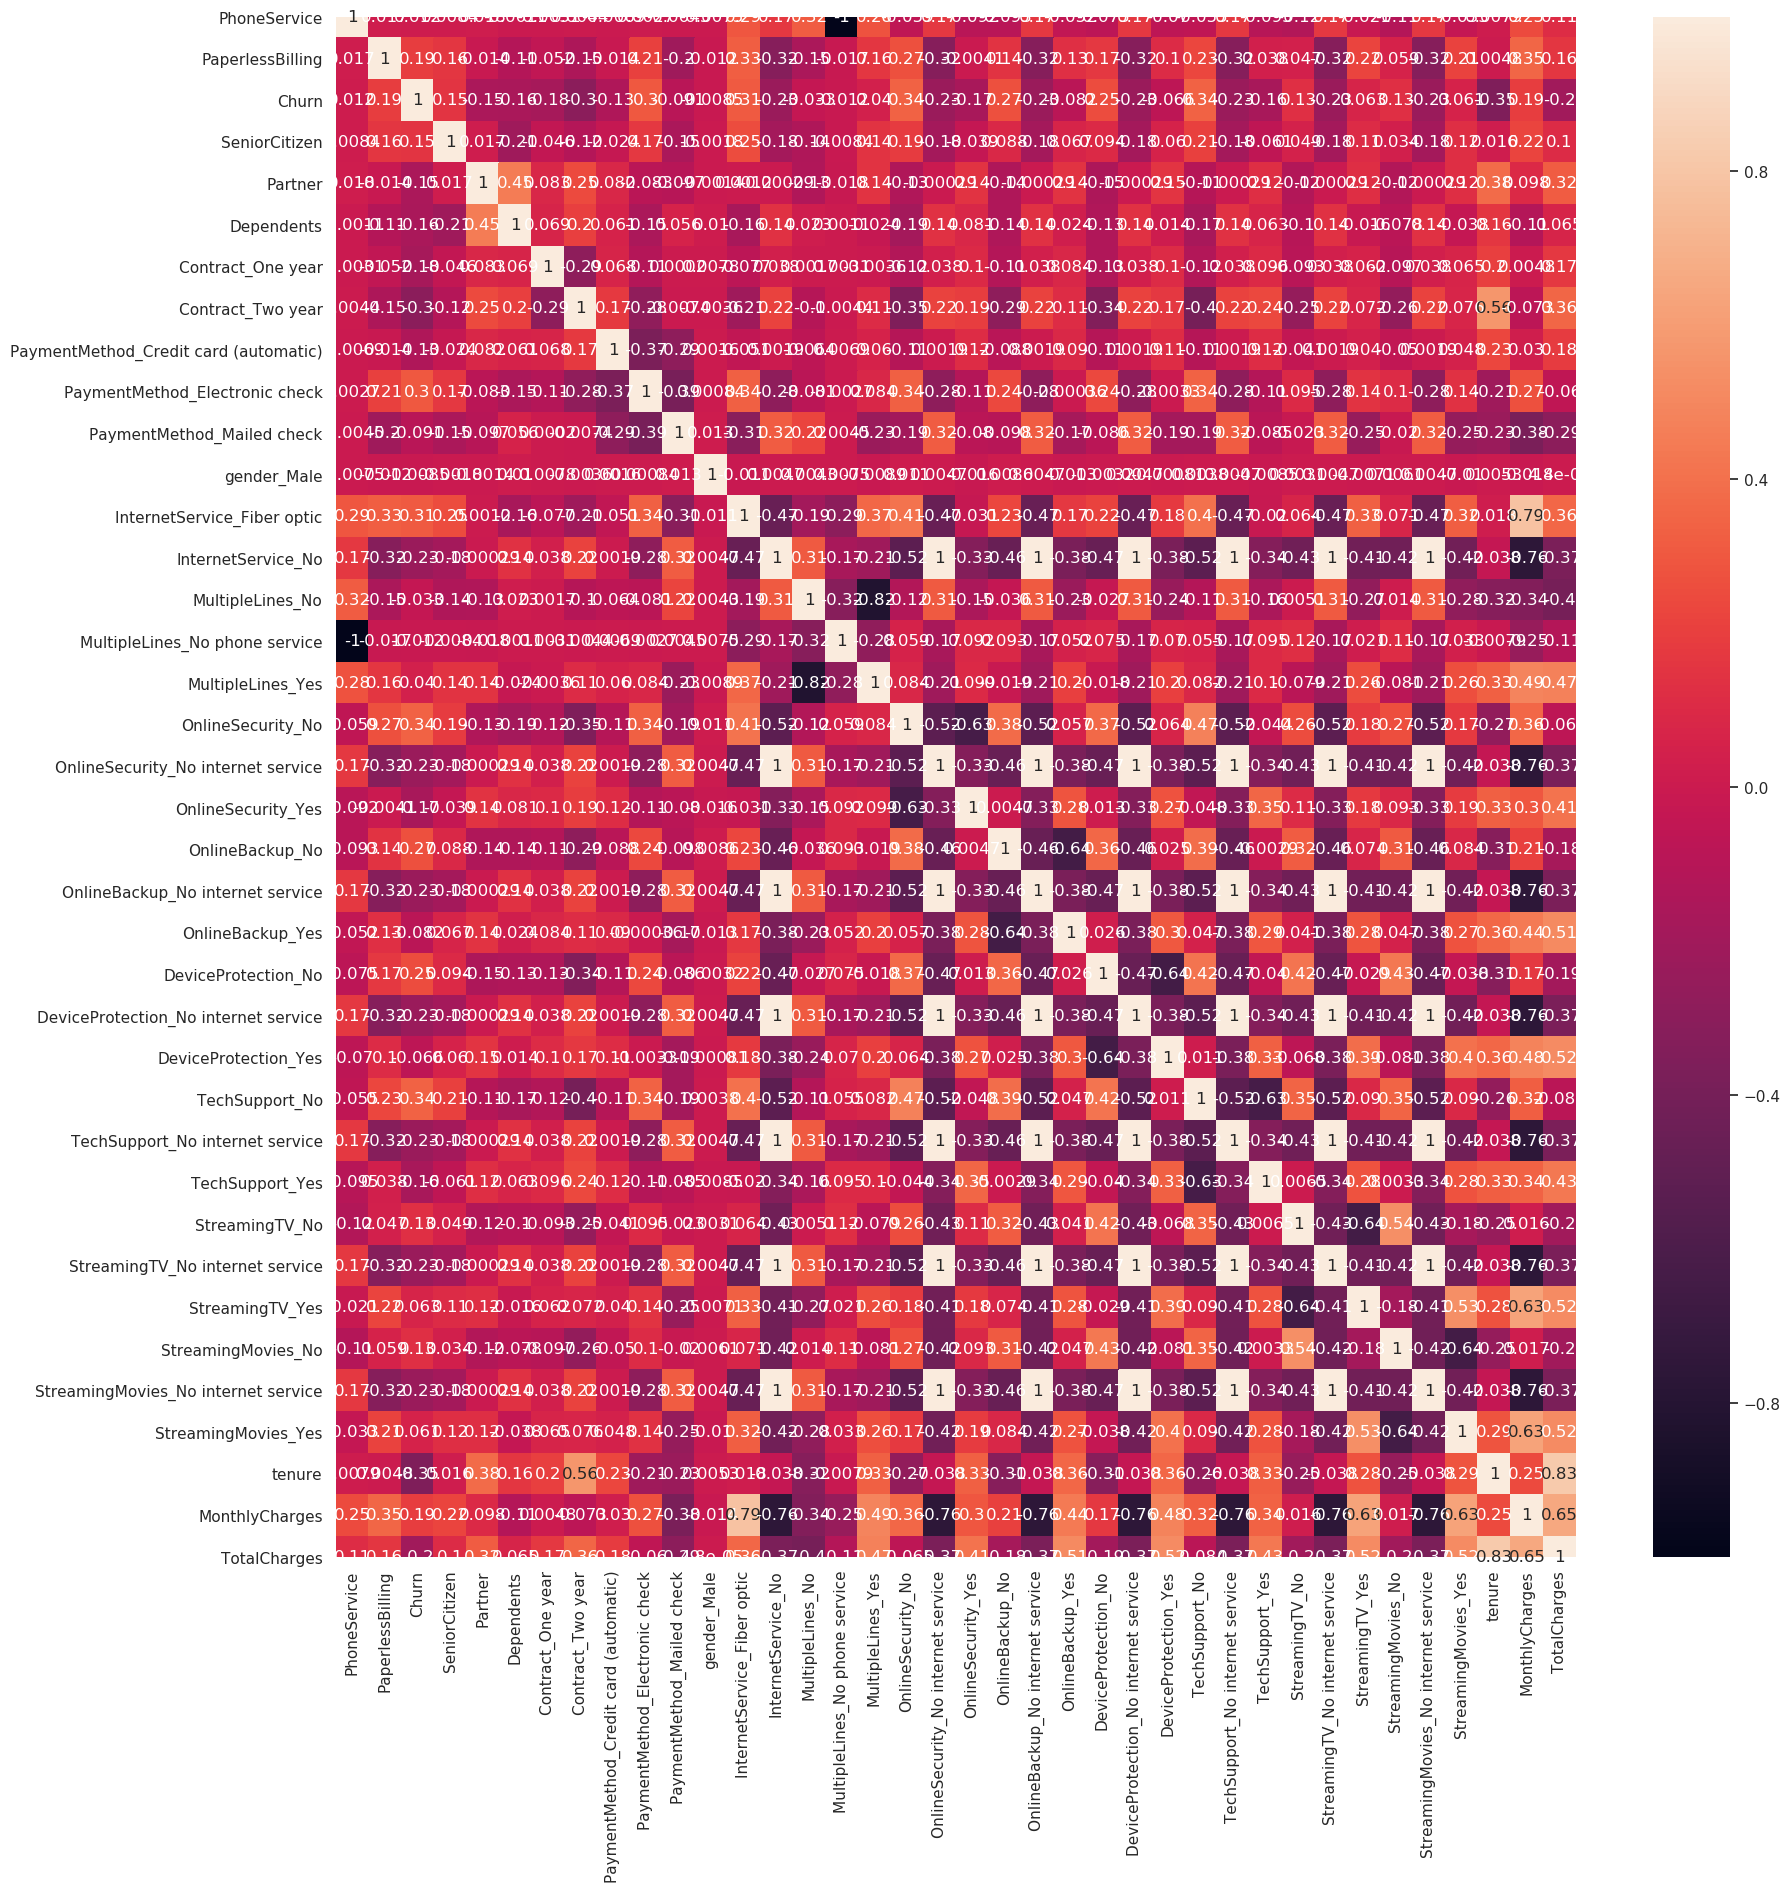

In [25]:
from src.visualization.eda_bivariate import bivar_corr_plot
bivar_corr_plot(telecom,"beforePCA")

#### PCA on the data

- While computng the principal components, we must not include the entire dataset. Model building is all about doing well on the data we haven't seen yet!
- So we'll calculate the PCs using the train data, and apply them later on the test data

- Since we are not sure on how many principle components are to be created, we will plot a scree plot and determine

In [26]:
from src.models.model_pca import generatePCA, generateScreePlot, generateIncrementalPCA

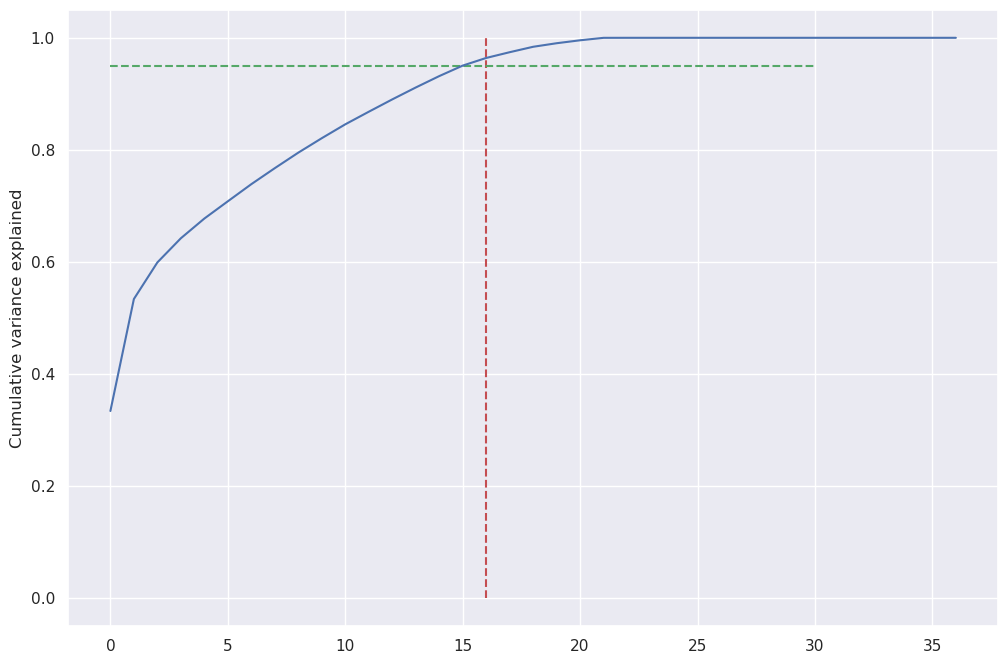

In [27]:
generateScreePlot(generatePCA(X_train))

- per the above scree plot, the number of optimal components is 16

In [28]:
pca_obj, df_train_pca = generateIncrementalPCA(X_train, 16)

- pca_final is the final set of components, lets serialise them so that we dont have to redo PCA again

#### Serialize PCA data

In [29]:
from src.models.model_serializer import serializePCA, deserializePCA

In [30]:
serializePCA(pca_obj)

2020-10-20 11:33:59,956 	 [INFO | model_serializer.py:21] > model serializer started
2020-10-20 11:33:59,960 	 [INFO | model_serializer.py:25] > model serializer completed successfully


#### Deserialize PCA object

In [31]:
pca_final = deserializePCA()

2020-10-20 11:34:00,055 	 [INFO | model_serializer.py:40] > model deserializer started
2020-10-20 11:34:00,058 	 [INFO | model_serializer.py:44] > model deserializer completed successfully


#### Check covariance on PCA components (PCA dataframe)

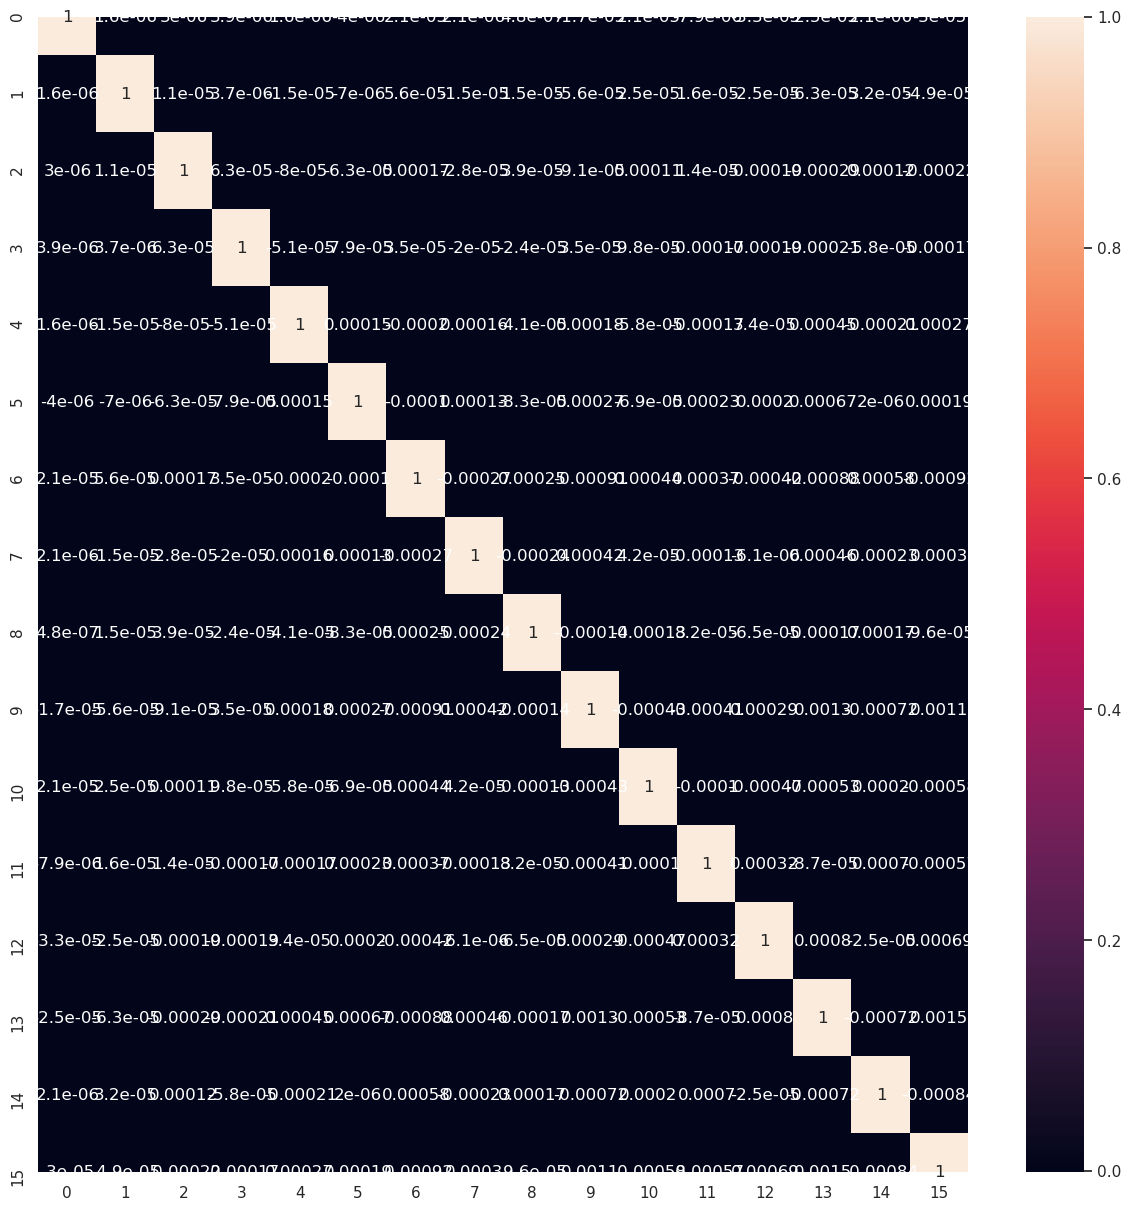

In [32]:
from src.models.model_pca import generateCorrPlotPCA
generateCorrPlotPCA(df_train_pca,"afterPCA")

- lets deserialize and use the pca_final 

In [33]:
from src.models.model_pca import generateTestSetPCA

In [34]:
df_test_pca = generateTestSetPCA(X_test, pca_final)

### Applying logistic regression on the data on our Principal components

In [35]:
from src.models.model_logisticRegression import generateLogRegPredictions, generateLogRegModel

In [46]:
model = generateLogRegModel(df_train_pca, y_train)

#### Serialize model

In [37]:
from src.models.model_serializer import serializeModel, deserializeModel

In [48]:
serializeModel(model)

2020-10-20 20:27:25,233 	 [INFO | model_serializer.py:12] > model serializer started
2020-10-20 20:27:25,239 	 [INFO | model_serializer.py:16] > model serializer completed successfully


#### Deserialize model

In [49]:
d_model = deserializeModel()

2020-10-20 20:27:26,997 	 [INFO | model_serializer.py:30] > model deserializer started
2020-10-20 20:27:27,001 	 [INFO | model_serializer.py:34] > model deserializer completed successfully


In [50]:
pred_probs_test = generateLogRegPredictions(d_model, df_test_pca)
pred_probs_train = generateLogRegPredictions(d_model, df_train_pca)

### Making Predictions

In [66]:
y_test_pred_df = pd.DataFrame(pred_probs_test)
y_test_pred_1 = y_test_pred_df.iloc[:,[1]] # convert to column
y_test_df = pd.DataFrame(y_test)
y_test_df['CustID'] = candID_test
y_test_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_test_pred_final = pd.concat([y_test_df,y_test_pred_1],axis=1)
y_test_pred_final= y_test_pred_final.rename(columns={ 1 : 'Churn_Prob'})
#y_pred_final = y_pred_final.reindex_axis(['CustID','Churn','Churn_Prob'], axis=1)
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head(10)

Churn      CustID  Churn_Prob  predicted
0      0  7567-ECMCM    0.422759          0
1      1  6771-XWBDM    0.222760          0
2      0  5356-KZCKT    0.031151          0
3      1  6140-QNRQQ    0.620115          1
4      0  9938-PRCVK    0.024903          0
5      1  5445-UTODQ    0.728775          1
6      0  9825-YCXWZ    0.259309          0
7      0  6518-PPLMZ    0.023828          0
8      1  9921-ZVRHG    0.702102          1
9      0  3099-OONVS    0.098440          0

In [67]:
y_train_pred_df = pd.DataFrame(pred_probs_train)
y_train_pred_1 = y_train_pred_df.iloc[:,[1]] # convert to column
y_train_df = pd.DataFrame(y_train)
y_train_df['CustID'] = candID_train
y_train_pred_1.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
y_train_pred_final = pd.concat([y_train_df,y_train_pred_1],axis=1)
y_train_pred_final= y_train_pred_final.rename(columns={ 1 : 'Churn_Prob'})
#y_pred_final = y_pred_final.reindex_axis(['CustID','Churn','Churn_Prob'], axis=1)
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head(10)

Churn      CustID  Churn_Prob  predicted
0      0  9342-VNIMQ    0.277518          0
1      0  0980-PVMRC    0.276597          0
2      1  0742-NXBGR    0.710060          1
3      1  9851-KIELU    0.520672          1
4      1  7295-JOMMD    0.597503          1
5      0  4570-QHXHL    0.507451          1
6      0  8676-OOQEJ    0.268005          0
7      1  9248-OJYKK    0.813582          1
8      0  3606-SBKRY    0.370810          0
9      1  9050-QLROH    0.579475          1

### Model Evaluation

In [68]:
from src.models.model_evaluation import generateROC_AUC_Score, generateAccuracyScore

In [69]:

#Training Scores
print ("Accuracy Score on Training dataset: " + generateAccuracyScore(y_train_pred_final.Churn, y_train_pred_final.predicted))
print ("ROC AUC Score on Training dataset: " + generateROC_AUC_Score(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob))


Accuracy Score on Training dataset: 0.80
ROC AUC Score on Training dataset: 0.84


In [70]:

#Testing Scores
print ("Accuracy Score on Test dataset: " + generateAccuracyScore(y_test_pred_final.Churn, y_test_pred_final.predicted))
print ("ROC AUC Score on Test dataset: " + generateROC_AUC_Score(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob))


Accuracy Score on Test dataset: 0.80
ROC AUC Score on Test dataset: 0.83
